In [21]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

### 데이터 로드 (q: 15분 단위, h: 1시간 단위)

In [22]:
generation_q = pd.read_csv(
    "/Users/jangseohyun/Documents/workspace/symply/DER/DATA_generation.csv"
)
generation_q["Time"] = pd.to_datetime(generation_q["Time"], format="%Y-%m-%d %H:%M")
generation_q["Hour"] = generation_q["Time"].dt.floor("h")
generation_h = generation_q.groupby("Hour").sum(numeric_only=True)

demand_q = pd.read_csv(
    "/Users/jangseohyun/Documents/workspace/symply/DER/DATA_demand.csv"
)
demand_q["Time"] = pd.to_datetime(demand_q["Time"], format="%Y-%m-%d %H:%M")
demand_q["Hour"] = demand_q["Time"].dt.floor("h")
demand_h = demand_q.groupby("Hour").sum(numeric_only=True)

price_q = pd.read_csv(
    "/Users/jangseohyun/Documents/workspace/symply/DER/DATA_price.csv"
)
price_q["Time"] = pd.to_datetime(price_q["Time"], format="%Y-%m-%d %H:%M")

### Set

In [23]:
I = list(range(len(generation_q.columns) - 2))
T = list(generation_q['Time'].dt.hour.unique())
S = list(range(20))
prob = {s: 1 / len(S) for s in S}

### 데이터 전처리

#### Generation

In [24]:
generation_avg = {
    (i, t): generation_h[generation_h.index.hour == t].mean()[i] for i in I for t in T
}

def generate_randomized_generation(I, T, S, generation_avg, randomness_level):
    np.random.seed(7)
    if randomness_level == 'low':
        noise_factors = {(i, t, s): np.random.uniform(0.8, 1.2) for i in I for t in T for s in S}
    elif randomness_level == 'medium':
        noise_factors = {(i, t, s): np.random.uniform(0.5, 1.5) for i in I for t in T for s in S}
    elif randomness_level == 'high':
        noise_factors = {(i, t, s): np.random.uniform(0.2, 1.8) for i in I for t in T for s in S}
    else:
        raise ValueError("Invalid randomness level. Please choose 'low', 'medium', or 'high'.")
    
    generation_r = {
        (i, t, s): generation_avg[(i, t)]*noise_factors[(i, t, s)] for i in I for t in T for s in S
    }
    return generation_r

/var/folders/2_/9m9qjphn0xs45xzpvf1hl0j00000gn/T/ipykernel_46078/298319970.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (i, t): generation_h[generation_h.index.hour == t].mean()[i] for i in I for t in T


#### Demand

In [25]:
demand_avg = {
    (i, t): demand_h[demand_h.index.hour == t].mean()[i] for i in I for t in T
}

def generate_randomized_demand(I, T, S, demand_avg, randomness_level):
    np.random.seed(17)
    if randomness_level == 'low':
        noise_factors = {(i, t, s): np.random.uniform(0.8, 1.2) for i in I for t in T for s in S}
    elif randomness_level == 'medium':
        noise_factors = {(i, t, s): np.random.uniform(0.5, 1.5) for i in I for t in T for s in S}
    elif randomness_level == 'high':
        noise_factors = {(i, t, s): np.random.uniform(0.2, 1.8) for i in I for t in T for s in S}
    else:
        raise ValueError("Invalid randomness level. Please choose 'low', 'medium', or 'high'.")
    
    demand_r = {
        (i, t, s): demand_avg[(i, t)]*noise_factors[(i, t, s)] for i in I for t in T for s in S
    }
    return demand_r

/var/folders/2_/9m9qjphn0xs45xzpvf1hl0j00000gn/T/ipykernel_46078/3962884240.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (i, t): demand_h[demand_h.index.hour == t].mean()[i] for i in I for t in T


#### Randomize

In [26]:
random_key = 'medium'

In [27]:
generation_r = generate_randomized_generation(I, T, S, generation_avg, random_key)
demand_r = generate_randomized_demand(I, T, S, demand_avg, random_key)

#### Residual = generation - demand

In [28]:
residual = {(i, t, s): generation_r[(i, t, s)] - demand_r[(i, t, s)] for i in I for t in T for s in S}

R = {
    (i, t, s): max(0, residual[(i, t, s)])
    for i in I for t in T for s in S
}

avg_R = sum(R.values()) / len(S)
print(f"s에 대한 R의 평균: {avg_R}")


s에 대한 R의 평균: 410.67458943913255


#### Price 설정

In [29]:
unique_days = generation_q['Time'].dt.normalize().unique()
days = len(unique_days)
S = list(range(min(len(S), days)))

price_q['Hour'] = price_q['Time'].dt.floor('H')
price_h = price_q.groupby('Hour').mean(numeric_only=True)  

price = price_h.iloc[:len(S)*len(T)]

P_DA = {t: sum(price['Price'].iloc[t + s * len(T)] for s in S) / len(S) * 1.2 for t in T}
P_RT = {(t, s): price['Price'].iloc[t + s * len(T)] for t in T for s in S}
P_PN = {t: sum(price['Price'].iloc[t + s * len(T)] for s in S) / len(S) * 2 for t in T}

/var/folders/2_/9m9qjphn0xs45xzpvf1hl0j00000gn/T/ipykernel_46078/2074225053.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  price_q['Hour'] = price_q['Time'].dt.floor('H')


### 모델 DER only

In [30]:
x_DA_1 = {(i, t): cp.Variable(pos=True) for i in I for t in T}
y_plus_1 = {(i, t, s): cp.Variable(pos=True) for i in I for t in T for s in S}
y_minus_1 = {(i, t, s): cp.Variable(pos=True) for i in I for t in T for s in S}

In [31]:
obj_case1 = sum(
    P_DA[t] * x_DA_1[i, t] for i in I for t in T
) + sum(
    prob[s] * (P_RT[t, s] * y_plus_1[i, t, s] - P_PN[t] * y_minus_1[i, t, s])
    for i in I for t in T for s in S
)

constraints_case1 = []

for i in I:
    for t in T:
        for s in S:
            constraints_case1.append(R[i, t, s] - x_DA_1[i, t] == y_plus_1[i, t, s] - y_minus_1[i, t, s])

for i in I:
    for t in T:
        for s in S:
            constraints_case1.append(R[i,t,s] >= y_plus_1[i, t, s])


M = max(R[i,t,s] for i in I for t in T for s in S)
z_case1 = {(i, t, s): cp.Variable(boolean=True) for i in I for t in T for s in S}
for i in I:
    for t in T:
        for s in S:
            constraints_case1.append(y_plus_1[i, t, s] <= M * z_case1[i, t, s])
            constraints_case1.append(y_minus_1[i, t, s] <= M * (1 - z_case1[i, t, s]))

prob_case1 = cp.Problem(cp.Maximize(obj_case1), constraints_case1)
prob_case1.solve(solver='GUROBI', IntFeasTol=1e-9, TimeLimit=60*30)

/opt/anaconda3/lib/python3.12/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


14401.2582774123

In [32]:
# # 결과 저장
# data = {
#     i: [x_DA_1[i, t].value for t in T] for i in I
# }
# df = pd.DataFrame(data, index=T)
# df.to_excel(f'./x_DA_1_results_rand{random_key}.xlsx')

# output_file = f"./y_plus_1_results_rand{random_key}.xlsx"

# with pd.ExcelWriter(output_file) as writer:
#     for i in I:
#         data = {
#             s: [y_plus_1[i, t, s].value for t in T] for s in S
#         }
#         df = pd.DataFrame(data, index=T)
        
#         sheet_name = f"i_{i}"
#         df.to_excel(writer, sheet_name=sheet_name)
        
# output_file = f"./y_minus_1_results_rand{random_key}.xlsx"

# with pd.ExcelWriter(output_file) as writer:
#     for i in I:
#         data = {
#             s: [y_minus_1[i, t, s].value for t in T] for s in S
#         }
#         df = pd.DataFrame(data, index=T)
        
#         sheet_name = f"i_{i}"
#         df.to_excel(writer, sheet_name=sheet_name)

### 결과 분석

In [33]:
# plt.figure(figsize=(5,3))
# for ss in range(40):
#     da_values = [x_DA_1[i, 14].value for i in I]
#     r_avg = [R[i, 14, ss] for i in I]
    
#     plt.plot(I, r_avg, label='R', color='tab:blue', linestyle='-', marker='o')
#     plt.plot(I, da_values, label='DA', color='tab:red', linestyle='-', marker='o')
#     plt.xlabel('i')
#     plt.ylabel('값')
#     plt.xticks(I)
#     plt.legend()
#     plt.grid(True)
#     plt.show()


In [34]:
# plt.figure(figsize=(5,3))
# for ss in range(40):
#     da_values = [x_DA_1[i, 13].value for i in I]
#     y_plus_avg = [y_plus_1[i, 13, ss].value for i in I]
#     y_minus_avg = [-y_minus_1[i, 13, ss].value for i in I]
#     r_avg = [R[i, 13, ss] for i in I]
    
#     # plt.plot(I, r_avg, label='R', color='tab:blue', linestyle='-', marker='o')
#     # plt.plot(I, da_values, label='DA', color='tab:red', linestyle='-', marker='o')
#     plt.bar(I, y_plus_avg, label='y+', color='tab:green')
#     plt.bar(I, y_minus_avg, label='y-', color='tab:orange')
#     plt.xlabel('i')
#     plt.ylabel('값')
#     plt.xticks(I)
#     plt.legend()
#     plt.grid(True)
#     plt.show()


In [35]:
# plt.figure(figsize=(5,3))
# ss = 3
# t = 13
# da_values = [x_DA_1[i, t].value for i in I]
# y_plus_avg = [y_plus_1[i, t, ss].value for i in I]
# y_minus_avg = [-y_minus_1[i, t, ss].value for i in I]
# r_avg = [R[i, t, ss] for i in I]
    
# # plt.plot(I, r_avg, label='R', color='tab:blue', linestyle='-', marker='o')
# # plt.plot(I, da_values, label='DA', color='tab:red', linestyle='-', marker='o')
# plt.bar(I, y_plus_avg, label='surplus energy', color='tab:green')
# plt.bar(I, y_minus_avg, label='shortage energy', color='tab:orange')
# plt.xlabel('i')
# plt.ylabel('값')
# plt.xticks(I)
# plt.legend()
# plt.grid(True)
# plt.show()


#### 수익 분석

In [36]:
# Day-ahead 수익 비교
total_da_profit_obj = 0
for i in I:
    for t in T:
        total_da_profit_obj += P_DA[t] * x_DA_1[i,t].value

# Real-time 수익 비교
total_rt_profit_obj = 0
for i in I:
    for t in T:
        for s in S:
            rt_profit_obj = P_RT[t, s] * y_plus_1[i, t, s].value
            total_rt_profit_obj += prob[s] * rt_profit_obj

# 패널티 비용 비교
total_penalty_cost_obj = 0
for i in I:
    for t in T:
        for s in S:
            penalty_cost_obj = P_PN[t] * y_minus_1[i, t, s].value
            total_penalty_cost_obj += prob[s] * penalty_cost_obj

# 총 시스템 이익 (목적 함수 기반)
total_system_profit_obj = total_da_profit_obj + total_rt_profit_obj - total_penalty_cost_obj

# 결과 출력
print(f"총 Day-ahead 수익 (_obj): {total_da_profit_obj:.2f}")
print(f"총 Real-time 수익 (_obj): {total_rt_profit_obj:.2f}")
print(f"총 Penalty 비용 (_obj): {total_penalty_cost_obj:.2f}")
print(f"목적 함수 기반 총 이익 (_obj): {total_system_profit_obj:.2f}")

총 Day-ahead 수익 (_obj): 3956.75
총 Real-time 수익 (_obj): 11184.79
총 Penalty 비용 (_obj): 740.28
목적 함수 기반 총 이익 (_obj): 14401.26


In [37]:
# 시간별 Day-ahead 수익 비교
time_da_profit_obj = {t: 0 for t in T}
for i in I:
    for t in T:
        time_da_profit_obj[t] += P_DA[t] * x_DA_1[i,t].value

# 시간별 Real-time 수익 비교
time_rt_profit_obj = {t: 0 for t in T}
for i in I:
    for t in T:
        for s in S:
            rt_profit_obj = P_RT[t, s] * y_plus_1[i, t, s].value
            time_rt_profit_obj[t] += prob[s] * rt_profit_obj

# 시간별 패널티 비용 비교
time_penalty_cost_obj = {t: 0 for t in T}
for i in I:
    for t in T:
        for s in S:
            penalty_cost_obj = P_PN[t] * y_minus_1[i, t, s].value
            time_penalty_cost_obj[t] += prob[s] * penalty_cost_obj

# 시간별 총 시스템 이익 (목적 함수 기반)
time_system_profit_obj = {t: time_da_profit_obj[t] + time_rt_profit_obj[t] - time_penalty_cost_obj[t] for t in T}

# 결과 출력
for t in T:
    # if t >= 10 and t <= 18:
        print(f"시간 {t} Day-ahead: {time_da_profit_obj[t]:.2f}")
        print(f"시간 {t} Real-time: {time_rt_profit_obj[t]:.2f}")
        print(f"시간 {t} Penalty: {time_penalty_cost_obj[t]:.2f}")
        print(f"시간 {t} 총 이익: {time_system_profit_obj[t]:.2f}")
        print()


시간 0 Day-ahead: 0.00
시간 0 Real-time: 0.00
시간 0 Penalty: 0.00
시간 0 총 이익: 0.00

시간 1 Day-ahead: 0.00
시간 1 Real-time: 0.00
시간 1 Penalty: 0.00
시간 1 총 이익: 0.00

시간 2 Day-ahead: 0.00
시간 2 Real-time: 0.00
시간 2 Penalty: 0.00
시간 2 총 이익: 0.00

시간 3 Day-ahead: 0.00
시간 3 Real-time: 0.00
시간 3 Penalty: 0.00
시간 3 총 이익: 0.00

시간 4 Day-ahead: 0.00
시간 4 Real-time: 0.00
시간 4 Penalty: 0.00
시간 4 총 이익: 0.00

시간 5 Day-ahead: 0.00
시간 5 Real-time: 0.00
시간 5 Penalty: 0.00
시간 5 총 이익: 0.00

시간 6 Day-ahead: 0.00
시간 6 Real-time: 0.00
시간 6 Penalty: 0.00
시간 6 총 이익: 0.00

시간 7 Day-ahead: 0.00
시간 7 Real-time: 0.00
시간 7 Penalty: 0.00
시간 7 총 이익: 0.00

시간 8 Day-ahead: 0.00
시간 8 Real-time: 16.12
시간 8 Penalty: 0.00
시간 8 총 이익: 16.12

시간 9 Day-ahead: 48.94
시간 9 Real-time: 231.38
시간 9 Penalty: 7.47
시간 9 총 이익: 272.85

시간 10 Day-ahead: 193.09
시간 10 Real-time: 878.17
시간 10 Penalty: 41.27
시간 10 총 이익: 1030.00

시간 11 Day-ahead: 636.11
시간 11 Real-time: 1427.59
시간 11 Penalty: 83.17
시간 11 총 이익: 1980.53

시간 12 Day-ahead: 1209.05
시간 12 R

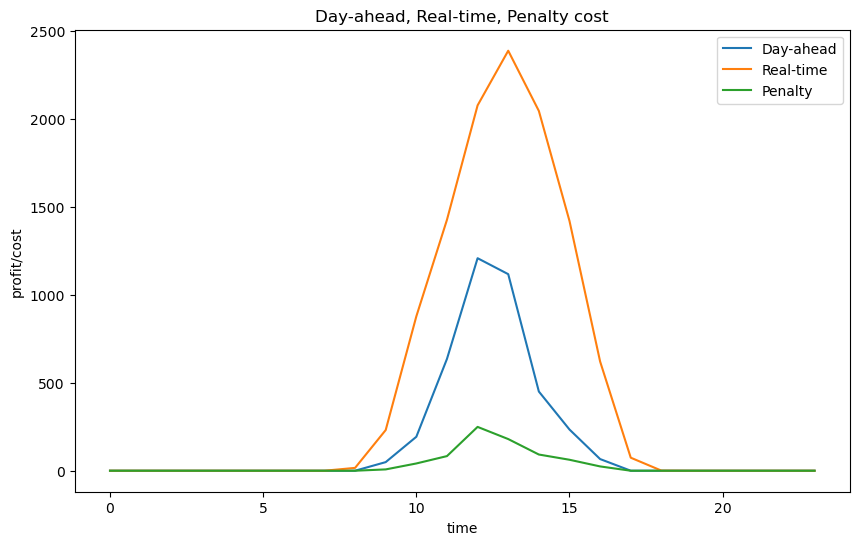

In [38]:
plt.figure(figsize=(10, 6))
plt.plot([t for t in T], [time_da_profit_obj[t] for t in T], label='Day-ahead')
plt.plot([t for t in T], [time_rt_profit_obj[t] for t in T], label='Real-time')
plt.plot([t for t in T], [time_penalty_cost_obj[t] for t in T], label='Penalty')
plt.xlabel('time')
plt.ylabel('profit/cost')
plt.title('Day-ahead, Real-time, Penalty cost')
plt.legend()
plt.show()

#### 하루 개인별 커밋량 합 분석

In [39]:
sum_x = 0
for t in T:
    time_sum = sum(x_DA_1[i,t].value for i in I)
    print(f"시간 {t}: {time_sum}")
    sum_x += time_sum
print(f"총 하루 commmit: {sum_x}")


시간 0: 0.0
시간 1: 0.0
시간 2: 0.0
시간 3: 0.0
시간 4: 0.0
시간 5: 0.0
시간 6: 0.0
시간 7: 0.0
시간 8: 0.0
시간 9: 1.80804966050583
시간 10: 6.097975887204738
시간 11: 19.41060820384213
시간 12: 27.435020799970623
시간 13: 24.90573460407353
시간 14: 10.575481375088653
시간 15: 5.222647260238361
시간 16: 1.475415124213726
시간 17: 0.0
시간 18: 0.0
시간 19: 0.0
시간 20: 0.0
시간 21: 0.0
시간 22: 0.0
시간 23: 0.0
총 하루 commmit: 96.9309329151376


In [40]:
alpha_DA = pd.read_csv('result_alpha_DA.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'result_alpha_DA.csv'

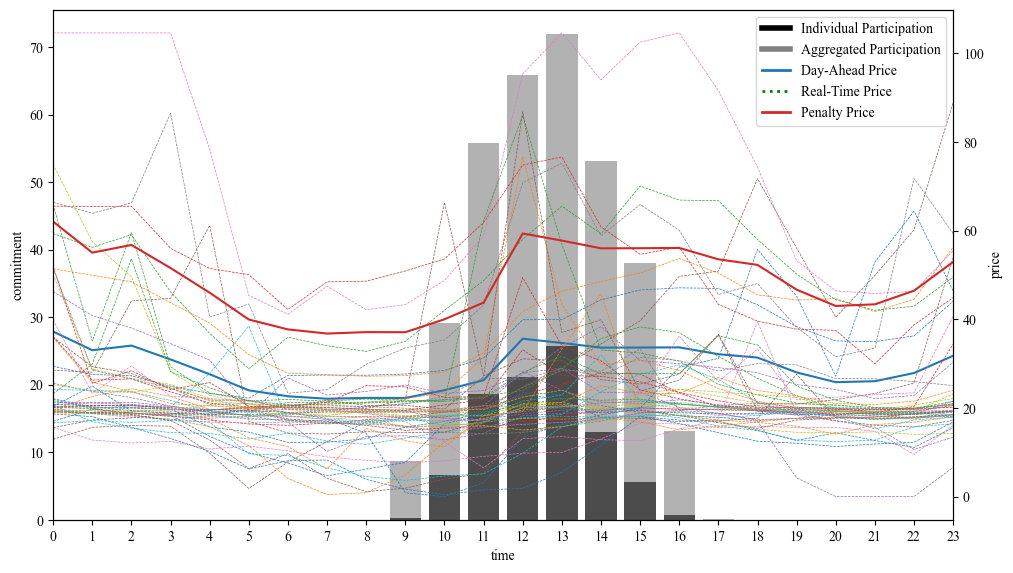

In [138]:
from matplotlib.lines import Line2D

plt.rc('font', family='Times New Roman')

fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 Y축 (막대그래프)
time_sums = [sum(x_DA_1[i, t].value for i in I) for t in T]
time_sum_bar = ax1.bar([t for t in T], time_sums, color='black', alpha=1)
alpha_DA_bar = ax1.bar([t for t in T], alpha_DA['alpha_DA'], color='grey', alpha=0.6)  # alpha_DA 추가
ax1.set_xlabel('time', fontname='Times New Roman')
ax1.set_ylabel('commitment', color='black', fontname='Times New Roman')
ax1.tick_params(axis='y', labelcolor='black', labelsize=10)

ax1.set_xlim(left=min(T), right=max(T))
ax1.spines['left'].set_position(('data', 0))

# 두 번째 Y축 (라인그래프)
ax2 = ax1.twinx()
P_DA_line = ax2.plot([t for t in T], [P_DA[t] for t in T], label='P_DA', linestyle='-', color='tab:blue')
RT_lines = []
for s in S:
    RT_line = ax2.plot([t for t in T], [P_RT[t, s] for t in T], linestyle='--', linewidth=0.5)  # Real-time Price를 초록색으로 설정
    RT_lines.append(RT_line[0])
P_PN_line = ax2.plot([t for t in T], [P_PN[t] for t in T], label='P_PN', linestyle='-', color='tab:red')
ax2.set_ylabel('price', color='black', fontname='Times New Roman')
ax2.tick_params(axis='y', labelcolor='black', labelsize=10)

# 커스텀 Legend 설정
custom_legend = [
    Line2D([0], [0], color='black', lw=4, label='Individual Participation'),
    Line2D([0], [0], color='grey', lw=4, label='Aggregated Participation'),
    Line2D([0], [0], color=P_DA_line[0].get_color(), lw=2, label='Day-Ahead Price'),
    Line2D([0], [0], color='green', linestyle=':', lw=2, label='Real-Time Price'),  # Real-Time Price 색상 설정
    Line2D([0], [0], color=P_PN_line[0].get_color(), lw=2, label='Penalty Price')
]

plt.legend(handles=custom_legend)

plt.xticks(T, fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1)
plt.show()


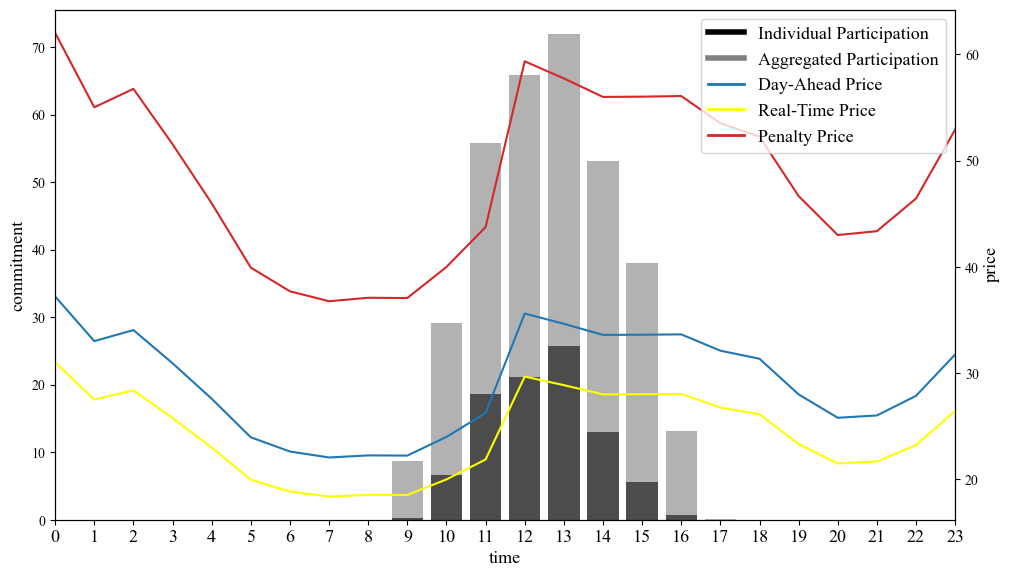

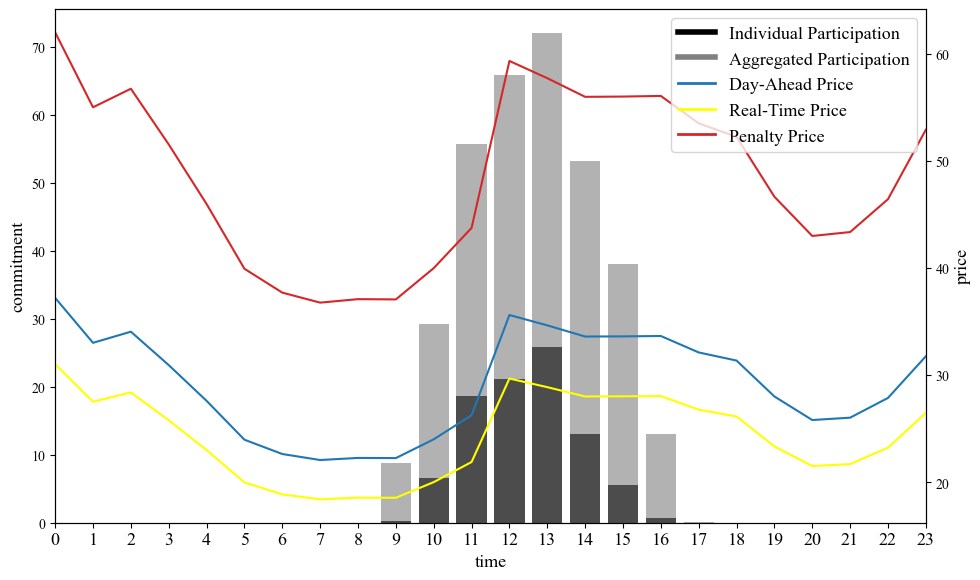

In [157]:
from matplotlib.lines import Line2D

plt.rc('font', family='Times New Roman', size=13)

fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 Y축 (막대그래프)
time_sums = [sum(x_DA_1[i, t].value for i in I) for t in T]
time_sum_bar = ax1.bar([t for t in T], time_sums, color='black', alpha=1)
alpha_DA_bar = ax1.bar([t for t in T], alpha_DA['alpha_DA'], color='grey', alpha=0.6)  # alpha_DA 추가
ax1.set_xlabel('time', fontname='Times New Roman')
ax1.set_ylabel('commitment', color='black', fontname='Times New Roman')
ax1.tick_params(axis='y', labelcolor='black', labelsize=10)

ax1.set_xlim(left=min(T), right=max(T))
ax1.spines['left'].set_position(('data', 0))

# 두 번째 Y축 (라인그래프)
ax2 = ax1.twinx()
P_DA_line = ax2.plot([t for t in T], [P_DA[t] for t in T], label='P_DA', linestyle='-', color='tab:blue')
RT_lines = []
# for s in S:
#     RT_line = ax2.plot([t for t in T], [P_RT[t, s] for t in T], linestyle='--', linewidth=0.5)  # Real-time Price를 초록색으로 설정
#     RT_lines.append(RT_line[0])
RT_line_avg = ax2.plot([t for t in T], [sum(P_RT[t, s] for s in S) / len(S) for t in T], linestyle='-', color='yellow')  # Real-time Price를 노랑색으로 설정
RT_lines.append(RT_line_avg[0])
P_PN_line = ax2.plot([t for t in T], [P_PN[t] for t in T], label='P_PN', linestyle='-', color='tab:red')
ax2.set_ylabel('price', color='black', fontname='Times New Roman')
ax2.tick_params(axis='y', labelcolor='black', labelsize=10)

# 커스텀 Legend 설정
custom_legend = [
    Line2D([0], [0], color='black', lw=4, label='Individual Participation'),
    Line2D([0], [0], color='grey', lw=4, label='Aggregated Participation'),
    Line2D([0], [0], color=P_DA_line[0].get_color(), lw=2, label='Day-Ahead Price'),
    Line2D([0], [0], color='yellow', lw=2, label='Real-Time Price'),  # Real-Time Price 색상 설정
    Line2D([0], [0], color=P_PN_line[0].get_color(), lw=2, label='Penalty Price')
]

plt.legend(handles=custom_legend)

plt.xticks(T, fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1)
plt.show()


fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 Y축 (막대그래프)
time_sums = [sum(x_DA_1[i, t].value for i in I) for t in T]
time_sum_bar = ax1.bar([t for t in T], time_sums, color='black', alpha=1)
alpha_DA_bar = ax1.bar([t for t in T], alpha_DA['alpha_DA'], color='grey', alpha=0.6)  # alpha_DA 추가
ax1.set_xlabel('time', fontname='Times New Roman')
ax1.set_ylabel('commitment', color='black', fontname='Times New Roman')
ax1.tick_params(axis='y', labelcolor='black', labelsize=10)

ax1.set_xlim(left=min(T), right=max(T))
ax1.spines['left'].set_position(('data', 0))

# 두 번째 Y축 (라인그래프)
ax2 = ax1.twinx()
P_DA_line = ax2.plot([t for t in T], [P_DA[t] for t in T], label='P_DA', linestyle='-', color='tab:blue')
RT_lines = []
# for s in S:
#     RT_line = ax2.plot([t for t in T], [P_RT[t, s] for t in T], linestyle='--', linewidth=0.5)  # Real-time Price를 초록색으로 설정
#     RT_lines.append(RT_line[0])
RT_line_avg = ax2.plot([t for t in T], [sum(P_RT[t, s] for s in S) / len(S) for t in T], linestyle='-', color='yellow')  # Real-time Price를 노랑색으로 설정
RT_lines.append(RT_line_avg[0])
P_PN_line = ax2.plot([t for t in T], [P_PN[t] for t in T], label='P_PN', linestyle='-', color='tab:red')
ax2.set_ylabel('price', color='black', fontname='Times New Roman')
ax2.tick_params(axis='y', labelcolor='black', labelsize=10)

# 커스텀 Legend 설정
custom_legend = [
    Line2D([0], [0], color='black', lw=4, label='Individual Participation'),
    Line2D([0], [0], color='grey', lw=4, label='Aggregated Participation'),
    Line2D([0], [0], color=P_DA_line[0].get_color(), lw=2, label='Day-Ahead Price'),
    Line2D([0], [0], color='yellow', lw=2, label='Real-Time Price'),  # Real-Time Price 색상 설정
    Line2D([0], [0], color=P_PN_line[0].get_color(), lw=2, label='Penalty Price')
]

plt.legend(handles=custom_legend)

plt.xticks(T, fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1)
plt.tight_layout()
plt.savefig('fig_price.pdf', bbox_inches='tight', pad_inches=0.05)


In [111]:
agg_da_profit_obj = pd.read_csv('result_time_da_profit_obj.csv')
agg_rt_profit_obj = pd.read_csv('result_time_rt_profit_obj.csv')
agg_penalty_cost_obj = pd.read_csv('result_time_penalty_cost_obj.csv')

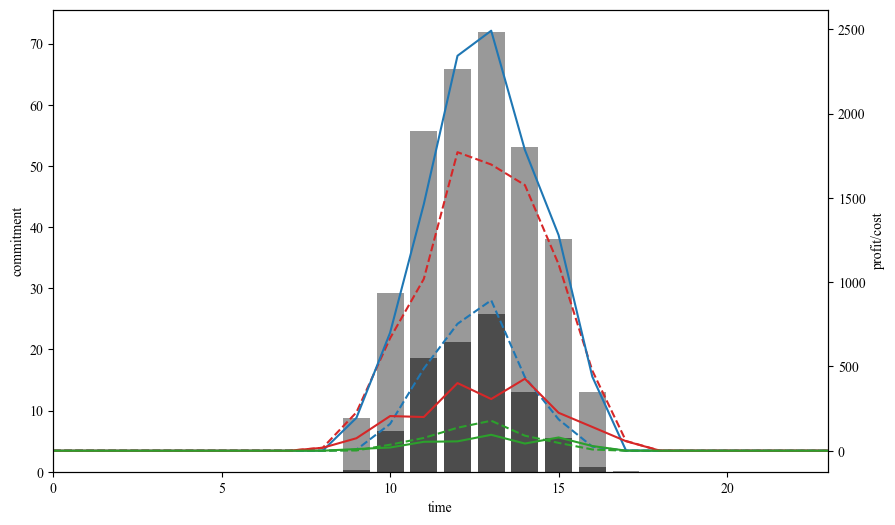

In [110]:
plt.rc('font', family='Times New Roman')
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 Y축 (막대그래프)
time_sums = [sum(x_DA_1[i, t].value for i in I) for t in T]
ax1.bar([t for t in T], time_sums, color='tab:grey', label='time_sum', alpha=1)
ax1.bar([t for t in T], alpha_DA['alpha_DA'], color='black', label='alpha_DA', alpha=0.4)  # alpha_DA 추가
ax1.set_xlabel('time', fontname='Times New Roman')
ax1.set_ylabel('commitment', color='black', fontname='Times New Roman')
ax1.tick_params(axis='y', labelcolor='black', labelsize=10)

# 두 번째 Y축 (라인그래프)
ax2 = ax1.twinx()
ax2.plot([t for t in T], [time_da_profit_obj[t] for t in T], label='Day-ahead', linestyle='--', color='tab:blue')
ax2.plot([t for t in T], [time_rt_profit_obj[t] for t in T], label='Real-time', linestyle='--', color='tab:red')
ax2.plot([t for t in T], [time_penalty_cost_obj[t] for t in T], label='Penalty', linestyle='--', color='tab:green')
ax2.plot([t for t in T], [agg_da_profit_obj['time_da_profit_obj'][t] for t in T], label='Day-ahead Profit', linestyle='-', color='tab:blue')
ax2.plot([t for t in T], [agg_rt_profit_obj['time_rt_profit_obj'][t] for t in T], label='Real-time Profit', linestyle='-', color='tab:red')
ax2.plot([t for t in T], [agg_penalty_cost_obj['time_penalty_cost_obj'][t] for t in T], label='Penalty Cost', linestyle='-', color='tab:green')

ax2.set_ylabel('profit/cost', color='black', fontname='Times New Roman')
ax2.tick_params(axis='y', labelcolor='black', labelsize=10)


ax1.set_xlim(left=min(T), right=max(T))
ax1.spines['left'].set_position(('data', 0))


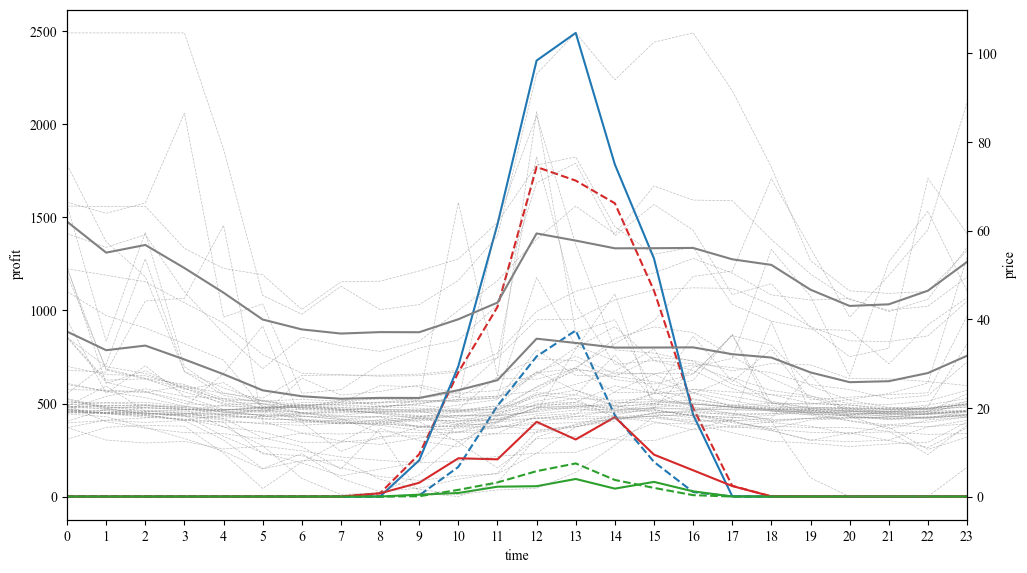

In [118]:
plt.rc('font', family='Times New Roman')

fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 Y축 (막대그래프)
ax1.plot([t for t in T], [time_da_profit_obj[t] for t in T], label='Day-ahead', linestyle='--', color='tab:blue')
ax1.plot([t for t in T], [time_rt_profit_obj[t] for t in T], label='Real-time', linestyle='--', color='tab:red')
ax1.plot([t for t in T], [time_penalty_cost_obj[t] for t in T], label='Penalty', linestyle='--', color='tab:green')
ax1.plot([t for t in T], [agg_da_profit_obj['time_da_profit_obj'][t] for t in T], label='Day-ahead Profit', linestyle='-', color='tab:blue')
ax1.plot([t for t in T], [agg_rt_profit_obj['time_rt_profit_obj'][t] for t in T], label='Real-time Profit', linestyle='-', color='tab:red')
ax1.plot([t for t in T], [agg_penalty_cost_obj['time_penalty_cost_obj'][t] for t in T], label='Penalty Cost', linestyle='-', color='tab:green')
ax1.set_xlabel('time', fontname='Times New Roman')
ax1.set_ylabel('profit', color='black', fontname='Times New Roman')
ax1.tick_params(axis='y', labelcolor='black', labelsize=10)

ax1.set_xlim(left=min(T), right=max(T))
ax1.spines['left'].set_position(('data', 0))

# 두 번째 Y축 (라인그래프)
ax2 = ax1.twinx()
ax2.plot([t for t in T], [P_DA[t] for t in T], label='P_DA', linestyle='-', color='grey')
for s in S:
    ax2.plot([t for t in T], [P_RT[t, s] for t in T], label=f'P_RT_{s}', linestyle='--', linewidth=0.5, color='grey', alpha=0.5)
ax2.plot([t for t in T], [P_PN[t] for t in T], label='P_PN', linestyle='-', color='grey')
ax2.set_ylabel('price', color='black', fontname='Times New Roman')
ax2.tick_params(axis='y', labelcolor='black', labelsize=10)

plt.xticks(T, fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1)
plt.show()


In [141]:
# 시간별로 agg profit과 time profit의 차이를 계산하고, 가장 차이가 많이 나는 시간과 해당 profit 종류를 찾습니다.
agg_profit_diff = {}
agg_da_profit_diff = {}
agg_rt_profit_diff = {}
agg_penalty_cost_diff = {}

for t in T:
    agg_profit_diff[t] = abs(agg_da_profit_obj['time_da_profit_obj'][t] - time_da_profit_obj[t]) + \
                          abs(agg_rt_profit_obj['time_rt_profit_obj'][t] - time_rt_profit_obj[t]) + \
                          abs(agg_penalty_cost_obj['time_penalty_cost_obj'][t] - time_penalty_cost_obj[t])
    agg_da_profit_diff[t] = abs(agg_da_profit_obj['time_da_profit_obj'][t] - time_da_profit_obj[t])
    agg_rt_profit_diff[t] = abs(agg_rt_profit_obj['time_rt_profit_obj'][t] - time_rt_profit_obj[t])
    agg_penalty_cost_diff[t] = abs(agg_penalty_cost_obj['time_penalty_cost_obj'][t] - time_penalty_cost_obj[t])

# 가장 차이가 많이 나는 시간과 해당 profit 종류를 찾습니다.
max_diff_time = max(agg_profit_diff, key=agg_profit_diff.get)
max_diff_time_da = max(agg_da_profit_diff, key=agg_da_profit_diff.get)
max_diff_time_rt = max(agg_rt_profit_diff, key=agg_rt_profit_diff.get)
max_diff_time_penalty = max(agg_penalty_cost_diff, key=agg_penalty_cost_diff.get)

print(f"가장 차이가 많이 나는 시간은 {max_diff_time}입니다. 이 시간에 대한 차이는 {agg_profit_diff[max_diff_time]}입니다.")
print(f"가장 차이가 많이 나는 Day-ahead profit은 {max_diff_time_da}입니다. 이 시간에 대한 차이는 {agg_da_profit_diff[max_diff_time]}입니다.")
print(f"가장 차이가 많이 나는 Real-time profit은 {max_diff_time_rt}입니다. 이 시간에 대한 차이는 {agg_rt_profit_diff[max_diff_time]}입니다.")
print(f"가장 차이가 많이 나는 Penalty cost은 {max_diff_time_penalty}입니다. 이 시간에 대한 차이는 {agg_penalty_cost_diff[max_diff_time]}입니다.")


가장 차이가 많이 나는 시간은 13입니다. 이 시간에 대한 차이는 3074.047213686076입니다.
가장 차이가 많이 나는 Day-ahead profit은 13입니다. 이 시간에 대한 차이는 1599.200541476781입니다.
가장 차이가 많이 나는 Real-time profit은 13입니다. 이 시간에 대한 차이는 1391.3098626372232입니다.
가장 차이가 많이 나는 Penalty cost은 13입니다. 이 시간에 대한 차이는 83.53680957207197입니다.


In [143]:
# 13시의 P_DA, P_RT, Penalty Cost를 출력합니다.
print(f"13시의 P_DA 가격: {P_DA[13]}")
print(f"13시의 P_RT 가격 평균: {sum(P_RT[13, s] for s in S) / len(S)}")
print(f"13시의 Penalty Cost: {P_PN[13]}")


13시의 P_DA 가격: 34.636519200000016
13시의 P_RT 가격 평균: 28.863766000000012
13시의 Penalty Cost: 57.727532000000025


In [149]:
# 시간별 P_DA 가격의 평균을 계산합니다.
avg_p_da_price = {t: P_DA[t] for t in T}

# 시간별 P_DA 가격의 평균을 출력합니다.
for t, avg_price in avg_p_da_price.items():
    print(f"{t}시의 P_DA 가격 평균은 {avg_price}입니다.")


0시의 P_DA 가격 평균은 37.2065184입니다.
1시의 P_DA 가격 평균은 33.005779200000006입니다.
2시의 P_DA 가격 평균은 34.0460088입니다.
3시의 P_DA 가격 평균은 30.923853599999997입니다.
4시의 P_DA 가격 평균은 27.584954399999997입니다.
5시의 P_DA 가격 평균은 23.9544648입니다.
6시의 P_DA 가격 평균은 22.617257081939997입니다.
7시의 P_DA 가격 평균은 22.056060000000006입니다.
8시의 P_DA 가격 평균은 22.251419999999996입니다.
9시의 P_DA 가격 평균은 22.23648입니다.
10시의 P_DA 가격 평균은 23.9901048입니다.
11시의 P_DA 가격 평균은 26.243769599999997입니다.
12시의 P_DA 가격 평균은 35.6028528입니다.
13시의 P_DA 가격 평균은 34.636519200000016입니다.
14시의 P_DA 가격 평균은 33.591724799999994입니다.
15시의 P_DA 가격 평균은 33.60697439999999입니다.
16시의 P_DA 가격 평균은 33.64195920000001입니다.
17시의 P_DA 가격 평균은 32.10606959999999입니다.
18시의 P_DA 가격 평균은 31.347369599999993입니다.
19시의 P_DA 가격 평균은 27.991744799999996입니다.
20시의 P_DA 가격 평균은 25.79249999999999입니다.
21시의 P_DA 가격 평균은 26.011984799999997입니다.
22시의 P_DA 가격 평균은 27.85608000000001입니다.
23시의 P_DA 가격 평균은 31.7485896입니다.


In [145]:
# 각 시간별 실시간 가격의 평균을 계산합니다.
avg_rt_price = {t: sum(P_RT[t,s] for s in S) / len(S) for t in T}

# 각 시간별 평균 가격을 출력합니다.
for t, avg_price in avg_rt_price.items():
    print(f"{t}시의 평균 가격은 {avg_price}입니다.")


0시의 평균 가격은 31.005432입니다.
1시의 평균 가격은 27.504816000000005입니다.
2시의 평균 가격은 28.371674000000002입니다.
3시의 평균 가격은 25.769878입니다.
4시의 평균 가격은 22.987461999999997입니다.
5시의 평균 가격은 19.962054000000002입니다.
6시의 평균 가격은 18.847714234949997입니다.
7시의 평균 가격은 18.380050000000004입니다.
8시의 평균 가격은 18.542849999999998입니다.
9시의 평균 가격은 18.5304입니다.
10시의 평균 가격은 19.991754입니다.
11시의 평균 가격은 21.869808입니다.
12시의 평균 가격은 29.669044000000003입니다.
13시의 평균 가격은 28.863766000000012입니다.
14시의 평균 가격은 27.993104입니다.
15시의 평균 가격은 28.005811999999995입니다.
16시의 평균 가격은 28.034966000000008입니다.
17시의 평균 가격은 26.755057999999995입니다.
18시의 평균 가격은 26.122807999999996입니다.
19시의 평균 가격은 23.326454입니다.
20시의 평균 가격은 21.49374999999999입니다.
21시의 평균 가격은 21.676654입니다.
22시의 평균 가격은 23.213400000000007입니다.
23시의 평균 가격은 26.457158입니다.


#### 개인 수익 분석

In [15]:
# 모든 der의 profit 합계 계산
total_der_profit = 0
der_profit = {}
for i in I:
    # 각 der i의 profit 합계 계산
    der_profit[i] = sum(P_DA[t] * x_DA_1[i,t].value + sum(prob[s] * (P_RT[t,s] * y_plus_1[i,t,s].value - P_PN[t] * y_minus_1[i,t,s].value) for s in S) for t in T)
    total_der_profit += der_profit[i]

print("\nder_profit:")
for i, value in der_profit.items():
    print(f"{i}: {value:.2f}")

print(f"\n모든 der의 profit 합계: {total_der_profit:.2f}")



der_profit:
0: 912.57
1: 595.73
2: 941.72
3: 824.58
4: 547.22
5: 511.60
6: 1159.65
7: 820.22
8: 423.18
9: 606.98
10: 371.08
11: 87.75
12: 664.98
13: 533.54
14: 581.47
15: 467.51
16: 91.94
17: 498.09
18: 352.92

모든 der의 profit 합계: 10992.73


### 결과 저장

In [16]:
R_sum = {(i, t): sum(R[i, t, s] for s in S) / len(S) for i in I for t in T}
R_df = pd.DataFrame({i: {t: R_sum[i, t] for t in T} for i in I})
R_df.to_csv('result_R.csv', index=False)

pd.DataFrame(list(P_DA.items()), columns=['time', 'price']).to_csv('result_P_DA.csv', index=False)

total_x_da_1 = {t: sum(x_DA_1[i,t].value for i in I) for t in T}
total_x_da_1_df = pd.DataFrame({'total_x_da_1': total_x_da_1})
total_x_da_1_df.to_csv('result_total_X_DA.csv', index=False)

der_profit_value = pd.DataFrame({'der_profit_value': der_profit})
der_profit_value.to_csv('result_der_profit.csv', index=False)

only_value = pd.DataFrame({'only_value': [prob_case1.value]})
only_value.to_csv('result_only_value.csv', index=False)